In [42]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string # for text manipulation 
import warnings 
import numpy as np 
import pandas as pd # for data manipulation 
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore") #ignore warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [45]:
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
                   encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
0                                                                                                                      1599999 non-null int64
1467810369                                                                                                             1599999 non-null int64
Mon Apr 06 22:19:45 PDT 2009                                                                                           1599999 non-null object
NO_QUERY                                                                                                               1599999 non-null object
_TheSpecialOne_                                                                                                        1599999 non-null object
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D    1599999 non-null object
dtypes: int64(2), object(4)
memo

In [46]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
data.columns = DATASET_COLUMNS
data.head()

,target,ids,date,flag,user,TweetText
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
class_counts = data['target'].value_counts()
class_counts

4    800000
0    799999
Name: target, dtype: int64

In [47]:
data.drop(['ids','date','flag','user'],axis = 1,inplace = True)

In [48]:
data.head()

,target,TweetText
0,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,@Kwesidei not the whole crew


In [9]:
data["target"].unique()

array([0, 4])

In [49]:
num_samples = 20000

In [50]:
# Sample the specified number of samples from each class
positive_data = data[data.target == 4].sample(n=num_samples, random_state=42)
negative_data = data[data.target == 0].sample(n=num_samples, random_state=42)

# Combine the sampled data
balanced_data = pd.concat([positive_data, negative_data])

# Print the shapes of the sampled data
print(positive_data.shape)
print(negative_data.shape)
print(balanced_data.shape)

(20000, 2)
(20000, 2)
(40000, 2)


In [18]:
# positif_data = data[data.target==4].iloc[:25000,:]
# print(positif_data.shape)
# negative_data = data[data.target==0].iloc[:1000,:]
# print(negative_data.shape)

(25000, 2)
(1000, 2)


In [13]:
class_counts = data['target'].value_counts()
class_counts

4    800000
0    799999
Name: target, dtype: int64

In [14]:
print(balanced_data.shape)
balanced_data.head()

(40000, 2)


,target,TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x
1099035,4,#myweakness Is music and i live to meet the people who make it
1275977,4,figured out the Internet on my new iPod
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success


# Data Cleaning

Removing Twitter Handles (@user)

In [51]:
balanced_data['Clean_TweetText'] = balanced_data['TweetText'].str.replace("@", "") 
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x
1099035,4,#myweakness Is music and i live to meet the people who make it,#myweakness Is music and i live to meet the people who make it
1275977,4,figured out the Internet on my new iPod,figured out the Internet on my new iPod
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun,hillsongunited can't wait to worship with you guys tonight. it'll be so much fun
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success,sillybeggar Congrats James !! I'm sure the book is going to be a huge success


Removing links

In [52]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].str.replace(r"http\S+", "") 
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x
1099035,4,#myweakness Is music and i live to meet the people who make it,#myweakness Is music and i live to meet the people who make it
1275977,4,figured out the Internet on my new iPod,figured out the Internet on my new iPod
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun,hillsongunited can't wait to worship with you guys tonight. it'll be so much fun
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success,sillybeggar Congrats James !! I'm sure the book is going to be a huge success


Removing Punctuations, Numbers, and Special Characters

In [53]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].str.replace("[^a-zA-Z]", " ") 
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x,Is lookin ward to a long weekend really dont want to go to work day tho x
1099035,4,#myweakness Is music and i live to meet the people who make it,myweakness Is music and i live to meet the people who make it
1275977,4,figured out the Internet on my new iPod,figured out the Internet on my new iPod
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun,hillsongunited can t wait to worship with you guys tonight it ll be so much fun
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success,sillybeggar Congrats James I m sure the book is going to be a huge success


Remove stop words

In [54]:
stopwords=nltk.corpus.stopwords.words('english')

In [55]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [56]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda text : remove_stopwords(text.lower()))
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x,lookin ward long weekend really dont want go work day tho x
1099035,4,#myweakness Is music and i live to meet the people who make it,myweakness music live meet people make
1275977,4,figured out the Internet on my new iPod,figured internet new ipod
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun,hillsongunited wait worship guys tonight much fun
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success,sillybeggar congrats james sure book going huge success


Text Tokenization and Normalization

In [57]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda x: x.split())
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x,"[lookin, ward, long, weekend, really, dont, want, go, work, day, tho, x]"
1099035,4,#myweakness Is music and i live to meet the people who make it,"[myweakness, music, live, meet, people, make]"
1275977,4,figured out the Internet on my new iPod,"[figured, internet, new, ipod]"
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun,"[hillsongunited, wait, worship, guys, tonight, much, fun]"
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success,"[sillybeggar, congrats, james, sure, book, going, huge, success]"


In [58]:
from nltk.stem.porter import * 

stemmer = PorterStemmer()

balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda x: [stemmer.stem(i) for i in x])
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x,"[lookin, ward, long, weekend, realli, dont, want, go, work, day, tho, x]"
1099035,4,#myweakness Is music and i live to meet the people who make it,"[myweak, music, live, meet, peopl, make]"
1275977,4,figured out the Internet on my new iPod,"[figur, internet, new, ipod]"
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun,"[hillsongunit, wait, worship, guy, tonight, much, fun]"
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success,"[sillybeggar, congrat, jame, sure, book, go, huge, success]"


Now let’s stitch these tokens back together

In [59]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x]))
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x,lookin ward long weekend realli dont want go work day tho x
1099035,4,#myweakness Is music and i live to meet the people who make it,myweak music live meet peopl make
1275977,4,figured out the Internet on my new iPod,figur internet new ipod
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun,hillsongunit wait worship guy tonight much fun
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success,sillybeggar congrat jame sure book go huge success


Removing small words

In [60]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont want to go to work 2day tho =[ x,lookin ward long weekend realli dont want work
1099035,4,#myweakness Is music and i live to meet the people who make it,myweak music live meet peopl make
1275977,4,figured out the Internet on my new iPod,figur internet ipod
1388987,4,@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun,hillsongunit wait worship tonight much
938858,4,@sillybeggar Congrats James !! I'm sure the book is going to be a huge success,sillybeggar congrat jame sure book huge success


Data Vizualisation

In this section we will visualize the tweets using wordclouds.
A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

What are the most common words in the entire dataset?

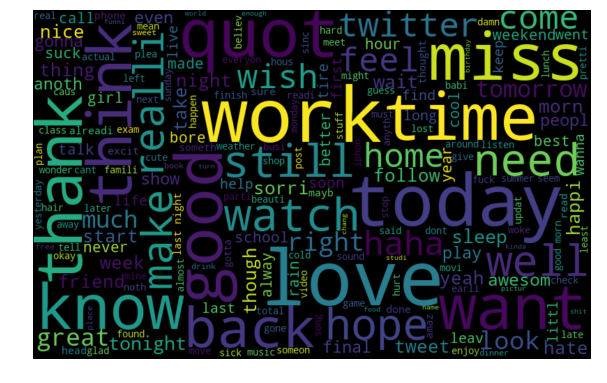

In [26]:
all_words = ' '.join([text for text in balanced_data['Clean_TweetText']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

What are the most common words in the dataset for Positive and Depressive tweets, respectively?

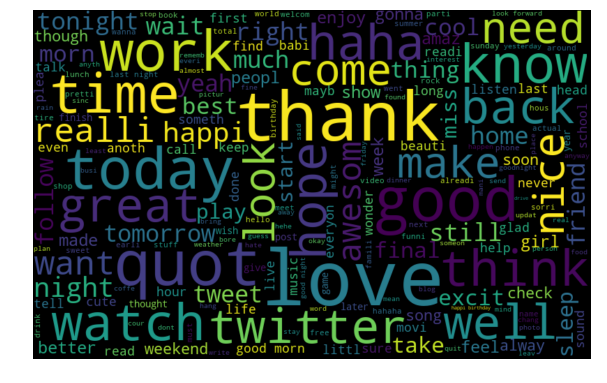

In [27]:
positive_words =' '.join([text for text in balanced_data['Clean_TweetText'][balanced_data['target'] == 4]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

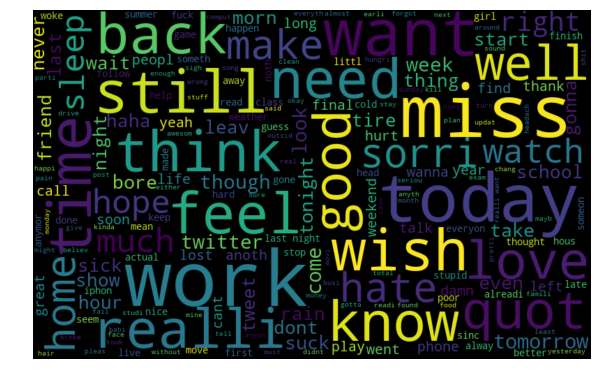

In [28]:
depressive_words =' '.join([text for text in balanced_data['Clean_TweetText'][balanced_data['target'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(depressive_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

# Model building

## Classic Algorithms

In [29]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
count_vectorizer = CountVectorizer(stop_words='english') 
cv = count_vectorizer.fit_transform(balanced_data['Clean_TweetText'])
cv.shape

(40000, 36362)

In [32]:
X_train,X_test,y_train,y_test = train_test_split(cv,balanced_data['target'],
                                                 test_size=.2,
                                                 stratify=balanced_data['target'],
                                                 random_state=42)

Model Training

### XGBoost

In [ ]:
xgbc = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
xgbc.fit(X_train,y_train)
prediction_xgb = xgbc.predict(X_test)
print(accuracy_score(prediction_xgb,y_test))

### RandomForest

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train,y_train)
prediction_rf = rf.predict(X_test)
print(accuracy_score(prediction_rf,y_test))

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
prediction_lr = lr.predict(X_test)
print(accuracy_score(prediction_lr,y_test))

### Support Vector Machine

In [ ]:
svc = svm.SVC()
svc.fit(X_train,y_train)
prediction_svc = svc.predict(X_test)
print(accuracy_score(prediction_svc,y_test))

## LLM

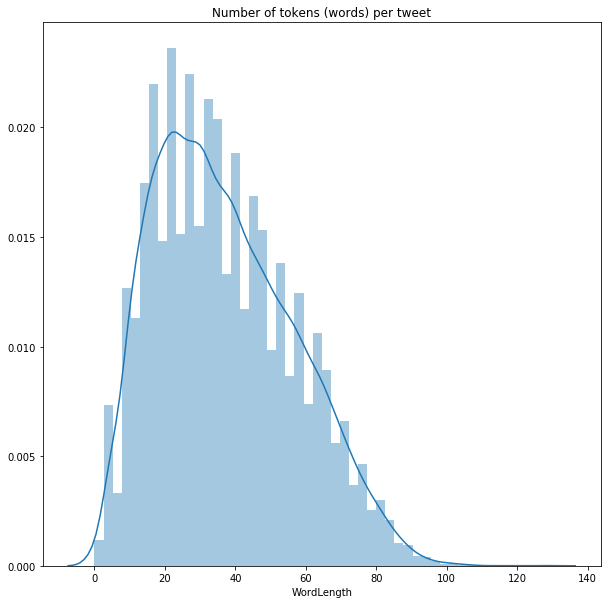

In [61]:
balanced_data['WordLength'] = balanced_data['Clean_TweetText'].str.len()
fig = plt.figure(figsize=(10,10))
sns.distplot(balanced_data['WordLength'])
plt.title('Number of tokens (words) per tweet')
plt.show()

In [62]:
balanced_data['target'] = balanced_data['target'].replace(4, 1)

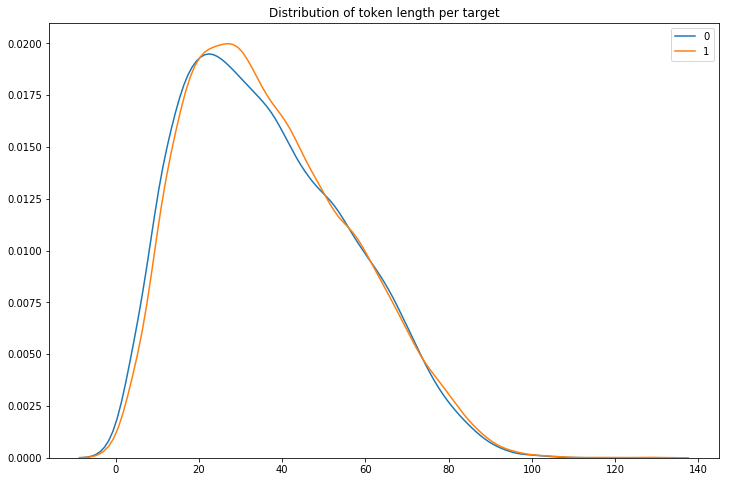

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
for sentiment in [0, 1]:
    sns.kdeplot(balanced_data[balanced_data['target']==sentiment]['WordLength'],ax=ax, label=sentiment)
ax.legend()
ax.set_title('Distribution of token length per target')
plt.show();

In [ ]:
from sklearn.model_selection import train_test_split

train_valid_data, test_data = train_test_split(balanced_data, train_size=0.8, shuffle=True, random_state=42,
                                               stratify=balanced_data['target'])

train_data, valid_data = train_test_split(train_valid_data, train_size=0.8, shuffle=True, random_state=42,
                                          stratify=balanced_data['target'])

In [67]:
print('{:>5,} Training samples'.format(len(train_data)))
print('{:>5,} Test samples'.format(len(test_data)))
print('{:>5,} Validation samples'.format(len(valid_data)))

25,600 Training samples
8,000 Test samples
6,400 Validation samples


In [ ]:
!pip install transformers

In [69]:
import transformers
from torch.utils.data import Dataset
from transformers import AutoTokenizer

ModuleNotFoundError: No module named 'transformers'

In [66]:
class TextDataset(Dataset):
    def __init__(self, dataframe, max_length=150, tokenizer_name='bert-base-uncased'):
        self.texts = dataframe['Clean_TweetText'].values
        self.targets = dataframe['target'].values
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        return {
            'input_ids': torch.as_tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.as_tensor(attention_mask, dtype=torch.long),
            'targets': torch.as_tensor(target, dtype=torch.long),
            'text': text
        }

In [ ]:
train_dataset = TextDataset(train_data)
valid_dataset = TextDataset(valid_data)
test_dataset = TextDataset(test_data)